In [1]:
import pandas as pd
import numpy as np
import os
import itertools
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import rc
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_predict

from sklearn.datasets import load_wine
import sklearn.ensemble
import sklearn.linear_model
import sklearn.model_selection
import numpy as np
from sklearn.metrics import r2_score
np.random.seed(1)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import xgboost as xgb
import scipy.stats as st
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import linear_model
import math
import random
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform
import sys

from google.colab import drive

# mount google drive information in a google colaboratory directory
drive.mount('/content/gdrive')
path = r'gdrive/MyDrive/tesis_maestria/Utiles/datos_revenue/'  # path


Mounted at /content/gdrive


Some Functions

In [2]:
# %load frac_diff.py
def getWeights(d,size):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 
    
    @param d A non-negative real that represents the degree of the differentiation.
    @param size The number of items .
    @return A list with the fractionally differentiated coefficients.
    '''
    w=[1.]
    for k in range(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w


def getWeights_FFD(d,thres):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 
    
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres The minimum absolute value that helps the stop adding items to the list of coefficients.
    @return A list with the fractionally differentiated coefficients.
    '''
    w = [1.]
    k = 1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_)<thres:
            break
        w.append(w_)
        k+=1
    return np.array(w[::-1]).reshape(-1,1)
                                     
def fracDiff(series, d, thres=0.01):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    value of coefficients the window will have.
    
    @param series A time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            test_val = series.loc[loc,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc] = np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df,axis=1)
    return df

def fracDiff_FFD(series,d,thres=1e-5):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    coefficient the window will have.
    
    @param series A DataFrame of time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    w = getWeights_FFD(d,thres) # Constant width window (new solution)
    width = len(w)-1
    df={}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0 = seriesF.index[iloc1-width]
            loc1 = seriesF.index[iloc1]
            test_val = series.loc[loc1,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

def compute_multiple_ffd(close, threshold, dd):
    from statsmodels.tsa.stattools import adfuller
    out = pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    df0 = close
    for d in dd:
        df1 = np.log(df0).resample('1D').last().dropna() # downcast to daily obs. Dropped NAs
        df2 = fracDiff_FFD(df1, d, thres=threshold).dropna()
        corr = np.corrcoef(df1.loc[df2.index,'close'], df2['close'])[0,1]
        df2 = adfuller(df2['close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']]+[corr] # with critical value
    return out

def get_d_optim(out, conf=0.05):
    return out[out.pVal < conf].pVal.idxmax()

Realizaremos uan regresión lineal para evaluar la sensibilidad del Economic Value of Information respecto al AUC de un algoritmo de machine learning.

***Armo el dataset que necesito***

In [4]:
df_revenue = pd.read_csv(path+'df_revenue_2020.csv',parse_dates=['ts'])
df_revenue['ts'] = df_revenue.ts.dt.date
df_seg = pd.read_csv(path+'df_segments.csv')
columns_to_keep = ['id','fullname']
df_seg = df_seg[columns_to_keep]
df_revenue = pd.merge(df_revenue, df_seg, how='left', left_on='seg_id', right_on='id')
columns_to_keep = ['ts','seg_id','imps','revenue','year','month','fullname']
df_revenue = df_revenue[columns_to_keep]
df_revenue = df_revenue[df_revenue['imps']>999] 
print(df_revenue.columns)
df_revenue = df_revenue.sort_values('ts', ascending=True)
df_revenue = pd.DataFrame(df_revenue.groupby(['ts','year','month','seg_id','fullname']).sum()).reset_index()
df_revenue = pd.DataFrame(df_revenue.groupby(['ts','year','month','seg_id','fullname']).sum()).reset_index()
df_revenue.tail(3)

Index(['ts', 'seg_id', 'imps', 'revenue', 'year', 'month', 'fullname'], dtype='object')


,ts,year,month,seg_id,fullname,imps,revenue
157023,2020-12-31,2020,12,489827,Deportes - Buen Fin / Black Friday / Cyber Monday,8206,13.59730
157024,2020-12-31,2020,12,489831,Vehiculos - Buen Fin / Black Friday / Cyber Mo...,8129,5.12127
157025,2020-12-31,2020,12,489835,Tecnologia - Buen Fin / Black Friday / Cyber M...,3859,2.43117


GROUND THRUT

In [5]:
print(df_revenue[df_revenue["fullname"].str.contains(r"(Branded)")]['revenue'].sum())
print(df_revenue[df_revenue["fullname"].str.contains(r"(Branded)")]['imps'].sum())
revenuei=df_revenue[df_revenue["fullname"].str.contains(r"(Branded)")]
revenuei['type'] = 0
revenuei.tail(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


834844.8975527
996191357


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,ts,year,month,seg_id,fullname,imps,revenue,type
157019,2020-12-31,2020,12,419395,Branded Data > Equifax > Chile > Base 10% AFP ...,1069,1.60350,0
157020,2020-12-31,2020,12,425859,Branded Data > Acxiom > Acxiom Mobile > Mexico...,1167,1.38750,0
157021,2020-12-31,2020,12,425895,Branded Data > Acxiom > Acxiom Mobile > Mexico...,10590,12.04654,0


MODELADO


In [6]:
print(df_revenue[~df_revenue["fullname"].str.contains(r"(Branded)")]['revenue'].sum())
print(df_revenue[~df_revenue["fullname"].str.contains(r"(Branded)")]['imps'].sum())
revenuec = df_revenue[~df_revenue["fullname"].str.contains(r"(Branded)")]
revenuec['type'] = 1
revenuec.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


2729549.94002816
4925972221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,ts,year,month,seg_id,fullname,imps,revenue,type
156994,2020-12-31,2020,12,306281,Coronavirus > Movilidad > Solo por el Barrio,2928,1.81404,1
157022,2020-12-31,2020,12,489825,Belleza - Buen Fin / Black Friday / Cyber Monday,2784,1.75392,1
157023,2020-12-31,2020,12,489827,Deportes - Buen Fin / Black Friday / Cyber Monday,8206,13.59730,1
157024,2020-12-31,2020,12,489831,Vehiculos - Buen Fin / Black Friday / Cyber Mo...,8129,5.12127,1
157025,2020-12-31,2020,12,489835,Tecnologia - Buen Fin / Black Friday / Cyber M...,3859,2.43117,1


Algunos Gráficos

Text(0.5, 1.0, 'REVENUE')

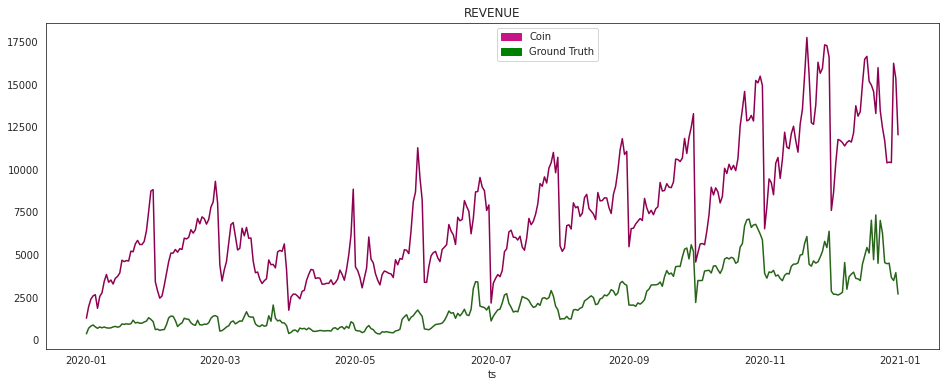

In [20]:
df_rev2_tmp = df_final.copy()[['ts','type','revenue']]
df_rev2_tmp.groupby(['ts','type']).agg({'revenue': np.sum}).unstack().plot(figsize=(16,6), cmap='PiYG_r').legend(title='Type of Gender Assigned',  loc='upper left', bbox_to_anchor=(0.5, 1))
sns.set_style("white")

# add legend
import matplotlib.patches as mpatches
top_bar = mpatches.Patch(color='mediumvioletred', label='Coin')
bottom_bar = mpatches.Patch(color='g', label='Ground Truth')
plt.legend(handles=[top_bar, bottom_bar], loc='upper left', bbox_to_anchor=(0.5, 1))

plt.title('REVENUE',fontsize=12)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'Revenue')

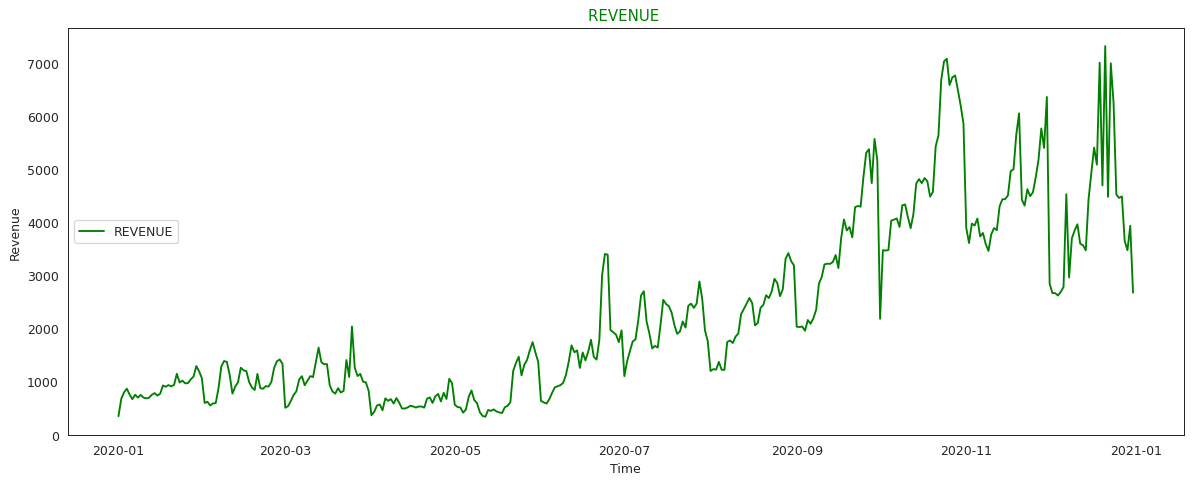

In [26]:
from matplotlib import pyplot             # Permite la generación de gráficos

revenuei=df_revenue[df_revenue["fullname"].str.contains(r"(Branded)")]
revenuei['type'] = 0
revenuei = revenuei[['ts','revenue']]
revenuei

df = revenuei.copy()
df = df.groupby(['ts']).agg({'revenue': np.sum})
sns.set_style("white")

fig = pyplot.figure(1, figsize=(16,6), dpi=90)
ax = fig.add_subplot(111)

X = df.reset_index()['ts']
C = df['revenue']

# Graficar revenue
plt.plot(X, C, color="g", linewidth=1.5, linestyle="-", label='REVENUE')

plt.legend(loc='center left')
plt.title("REVENUE ", loc='center', fontsize=12, fontweight=0, color='g')
plt.xlabel("Time")
plt.ylabel("Revenue")

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, 'Revenue')

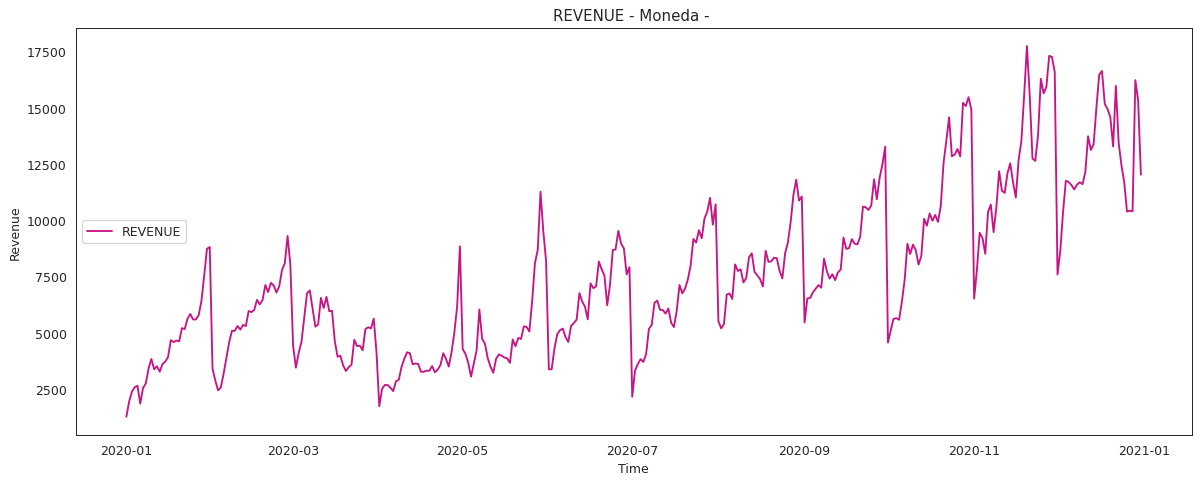

In [25]:
revenuec=df_revenue[~df_revenue["fullname"].str.contains(r"(Branded)")]
revenuec['type'] = 1
revenuec = revenuec[['ts','revenue']]

df = revenuec.copy()
df = df.groupby(['ts']).agg({'revenue': np.sum})
sns.set_style("white")

fig = pyplot.figure(1, figsize=(16,6), dpi=90)
ax = fig.add_subplot(111)

X = df.reset_index()['ts']
C = df['revenue']

# Graficar revenue
plt.plot(X, C, color="mediumvioletred", linewidth=1.5, linestyle="-", label='REVENUE')

plt.legend(loc='center left')
plt.title("REVENUE - Moneda - ", loc='center', fontsize=12, fontweight=0)
plt.xlabel("Time")
plt.ylabel("Revenue")

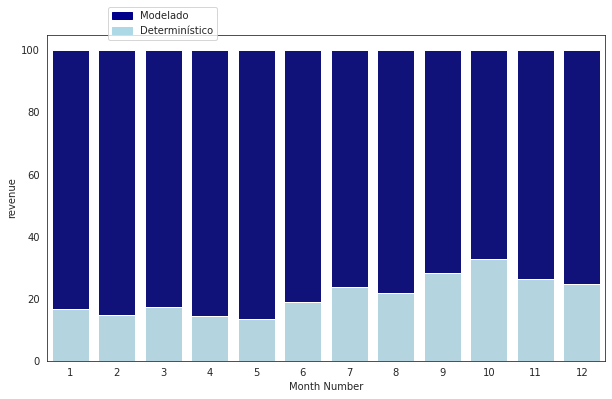

In [21]:
tips = df_final.copy()[['ts','type','revenue']].sort_values('ts', ascending=False)
# Convert strings to datetime

tips['ts'] = pd.to_datetime(tips.ts.astype(str), format='%Y/%m/%d %H:%M:%S')

# create colunms for date(day/month/year)

tips['ts'] = tips.ts.dt.month
tips = tips.rename(columns={'ts':'Month Number'})
# set the figure size
plt.figure(figsize=(10, 6))

# from raw value to percentage
total = tips.groupby('Month Number')['revenue'].sum().reset_index()
smoker = tips[tips['type']==0].groupby('Month Number')['revenue'].sum().reset_index()
smoker['revenue'] = [i / j * 100 for i,j in zip(smoker['revenue'], total['revenue'])]
total['revenue'] = [i / j * 100 for i,j in zip(total['revenue'], total['revenue'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="Month Number",  y="revenue", data=total, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="Month Number", y="revenue", data=smoker, color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='Modelado')
bottom_bar = mpatches.Patch(color='lightblue', label='Determinístico')
plt.legend(handles=[top_bar, bottom_bar], loc='upper left', bbox_to_anchor=(0.1,1.1))

# show the graph
plt.show()

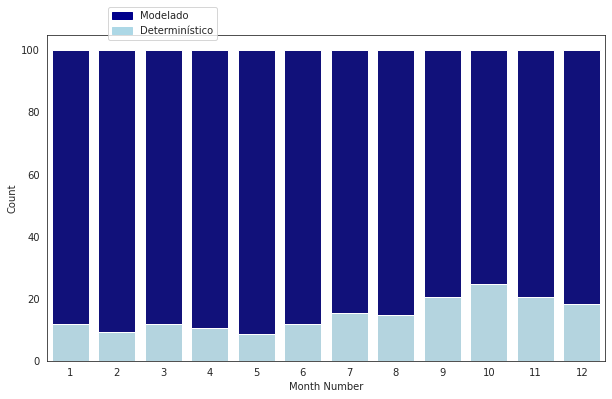

In [22]:
tips = df_final.copy()[['ts','type','imps']].sort_values('ts', ascending=False)
# Convert strings to datetime

tips['ts'] = pd.to_datetime(tips.ts.astype(str), format='%Y/%m/%d %H:%M:%S')

# create colunms for date(day/month/year)

tips['ts'] = tips.ts.dt.month
tips = tips.rename(columns={'ts':'Month Number',
                            'imps':'Count'})
# set the figure size
plt.figure(figsize=(10, 6))

# from raw value to percentage
total = tips.groupby('Month Number')['Count'].sum().reset_index()
smoker = tips[tips['type']==0].groupby('Month Number')['Count'].sum().reset_index()
smoker['Count'] = [i / j * 100 for i,j in zip(smoker['Count'], total['Count'])]
total['Count'] = [i / j * 100 for i,j in zip(total['Count'], total['Count'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="Month Number",  y="Count", data=total, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="Month Number", y="Count", data=smoker, color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='Modelado')
bottom_bar = mpatches.Patch(color='lightblue', label='Determinístico')
plt.legend(handles=[top_bar, bottom_bar], loc='upper left', bbox_to_anchor=(0.1,1.1))

# show the graph
plt.show()

Para regresion

In [7]:
revenuei = revenuei[['ts','type','imps','revenue']]
revenuei = revenuei.groupby('ts')['revenue','imps'].sum()
revenuei['type'] = 0
revenuei = revenuei.reset_index()

revenuec = revenuec[['ts','type','imps','revenue']]
revenuec = revenuec.groupby('ts')['revenue','imps'].sum()
revenuec['type'] = 1
revenuec = revenuec.reset_index()

df_final = pd.concat([revenuei, revenuec], axis=0)
df_final = df_final[['ts','type','imps','revenue']]
df_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,ts,type,imps,revenue
0,2020-01-01,0,374045,346.002193
1,2020-01-02,0,673859,674.644850
2,2020-01-03,0,801364,795.166526
3,2020-01-04,0,882656,864.581860
4,2020-01-05,0,785051,754.636010
...,...,...,...,...
361,2020-12-27,1,16992200,10417.726719
362,2020-12-28,1,17166545,10390.754428
363,2020-12-29,1,28742044,16218.099102
364,2020-12-30,1,26660133,15320.685633


Test Dickey Fuller para corroborar estacionariedad de la serie

In [12]:
from statsmodels.tsa.stattools import adfuller
series = df_final.copy() 
series = series[['ts','revenue']]

series = series.set_index('ts')
X = series.revenue
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.361146
p-value: 0.153004
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


In [18]:
from statsmodels.tsa.stattools import adfuller
series = df_final.copy() 
series = series[['ts','imps']]

series = series.set_index('ts')
X = series.imps
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.228961
p-value: 0.934980
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [16]:
series = series.reset_index()
ds = np.linspace(0, 1, 21)
out = compute_multiple_ffd(series['imps'].to_frame(), 1e-3, ds)

In [ ]:
# Realizamos un plot para evaluar gráficamente el valor óptimo.
out[['adfStat','corr']].plot(secondary_y='adfStat')
mean_95conf = out['95% conf'].mean()
optim_d = get_d_optim(out, conf=0.05)
plt.axhline(mean_95conf,linewidth=1,color='r',linestyle='dotted')
plt.axvline(optim_d,linewidth=1,color='g',linestyle='dotted')
plt.grid()
plt.title('ADF Stat, Autorrelacion vs D')
print('Promedio de valores críticos para el estadístico al 5%: {}'.format(mean_95conf))
print('Valor óptimo de d: {}'.format(optim_d))

Prices=series['imps'].copy()
series['imps'] = fracDiff_FFD(series['imps'].to_frame(), d=optim_d, thres=1e-3)

In [ ]:
series['imps'] = fracDiff_FFD(series['imps'].to_frame(), d=optim_d, thres=1e-3)

# # Ploteamos la series.
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
# series.plot(kind='line',y='imps', color='blue', ax=ax)
# series.plot(kind='line',y='impsFFD', color='green', ax=ax)
# plt.title('data prices and Optim FFD')
# plt.ylabel('Value')
# plt.grid()
# plt.show()

In [10]:
#Hago vol al cuadrado
df = df_final.copy()
df = df[['revenue','imps','type']]
df = df.rename(columns={'imps':'vol',
                        'type':'moneda',
                        'revenue':'y'})
df['vol2'] = df['vol'] ** 2
print(df.shape)
df.head()

(732, 4)


,y,vol,moneda,vol2
0,346.002193,374045,0,139909662025
1,674.644850,673859,0,454085951881
2,795.166526,801364,0,642184260496
3,864.581860,882656,0,779081614336
4,754.636010,785051,0,616305072601


In [11]:
# Set the features of our model, these are our potential inputs
revenue_features = ['vol','vol2','moneda']
# Set the variable X to be all our input columns: Temperature, Wind Speed and Pressure
X = df[revenue_features]
# set y to be our output column: Humidity
y = df.y

from sklearn.linear_model import LinearRegression
mlr_model = LinearRegression()
mlr_model.fit(X,y)
beta0 = mlr_model.intercept_
beta1, beta2, beta3 = mlr_model.coef_
beta0, beta1, beta2, beta3

(486.6857018529445,
 0.0006729879994693415,
 -3.1314963244200988e-12,
 -1393.0644022042518)

In [12]:
#With stats library
import pandas as pd                    ## Este proporciona una estructura similiar a los data.frame
import statsmodels.api as sm           ## Este proporciona funciones para la estimación de muchos modelos estadísticos
import statsmodels.formula.api as smf  ## Permite ajustar modelos estadísticos utilizando fórmulas de estilo R

mod = smf.ols('y ~ vol + vol2 + moneda', data=df).fit()  # Ajusta el modelo usando el registro natural de uno de los regresores
print(mod.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.384e+04
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        02:38:55   Log-Likelihood:                -5591.6
No. Observations:                 732   AIC:                         1.119e+04
Df Residuals:                     728   BIC:                         1.121e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    486.6857     38.833     12.533      0.0